In [1]:
# import all the required dependecnies and modules

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_theme(style="whitegrid")
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import pickle
from google.cloud import bigquery
from google.oauth2 import service_account
# from google.cloud import bigquery_storage_v1
import string
import xgboost as xgb
import importlib
import utility as ut
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")
import export_dataset as ed
import define_X_y as xy
import pre_processing as pp
import feature_engineering as fe
import feature_selection as fs
import model_training as mt
import model_evaluation as me
import lift_and_ks as ks

In [2]:
gcp_cred_json = 'ascendant-epoch-432900-m8-e97fb3b60497.json'
project_id = "ascendant-epoch-432900-m8"
dataset_id = "prop_model"
table_id = "new_churn"
input_query = """
    SELECT
      *
    FROM
      `ascendant-epoch-432900-m8.prop_model.new_churn`
    
"""

In [3]:
df = ed.export_dataset(gcp_cred_json, project_id, dataset_id, table_id, input_query)

DataFrame shape: (5000, 22)


In [4]:
print(display(df.head()))

,int64_field_0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Churn,ID
0,919,NJ,53,area_code_408,False,False,0,228.6,117,38.86,...,11.29,227.2,124,10.22,10.1,2,2.73,9,1,1919
1,988,KS,116,area_code_408,True,False,0,232.2,98,39.47,...,20.80,151.3,69,6.81,10.6,1,2.86,7,1,1988
2,2011,MI,146,area_code_408,False,False,0,149.3,83,25.38,...,15.90,149.8,100,6.74,7.9,4,2.13,7,1,3011
3,2090,HI,99,area_code_408,False,False,0,135.7,107,23.07,...,17.71,209.0,95,9.40,8.8,3,2.38,7,1,3090
4,2817,NH,103,area_code_408,False,False,0,150.6,125,25.60,...,14.37,221.2,104,9.95,10.4,8,2.81,8,1,3817


None


In [5]:
df = df.drop(columns = ['int64_field_0'])

In [6]:
not_use = ['customerID', 'Churn']
id = ['ID']
target = ['Churn']

In [7]:
importlib.reload(pp)
cat_col, num_col, X, y  = xy.X_y_columns(df, not_use, id, target)

Total customers:  5000
churners:  598
churn rate rate %:  11.96
total cat cols:  2
total num cols:  18
Cat Columns descriptions
--------------------------------------------------
Column: state
Number of unique values: 51
Unique values: ['NJ' 'KS' 'MI' 'HI' 'NH' 'KY' 'VT' 'AL' 'AR' 'OH' 'GA' 'WV' 'MN' 'SC'
 'FL' 'MD' 'IN' 'RI' 'ME' 'CT' 'OK' 'VA' 'OR' 'WY' 'WI' 'NM' 'DC' 'MA'
 'SD' 'PA' 'WA' 'CA' 'NY' 'CO' 'AZ' 'NC' 'ID' 'DE' 'IA' 'LA' 'AK' 'TN'
 'MT' 'IL' 'MS' 'NV' 'NE' 'TX' 'MO' 'UT' 'ND']
Value counts:
state
WV    158
MN    125
AL    124
ID    119
VA    118
TX    116
OH    116
WY    115
OR    114
NY    114
NJ    112
UT    112
WI    106
MA    103
ME    103
MI    103
MD    102
VT    101
KS     99
MS     99
KY     99
RI     99
CT     99
MT     99
WA     98
IN     98
CO     96
NH     95
DE     94
MO     93
AR     92
NC     91
NM     91
SC     91
OK     90
NV     90
FL     90
TN     89
AZ     89
NE     88
IL     88
ND     88
DC     88
HI     86
SD     85
GA     83
LA     82
PA     77
AK  

In [8]:
num_col.remove('ID')
num_col

['account_length',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls']

In [9]:
cat_col

['state', 'area_code']

In [10]:
X_PP = pp.pre_processing(X, cat_col, num_col)

**************************************************
Pre-Processing: SimpleImputer
**************************************************
**************************************************
Pre-Processing: SimpleImputer
**************************************************
**************************************************
Feature Engineering: Remove_ConstantFeatures
**************************************************
- It will remove features with 1 unique value(s).

[] []
0 features with 1 or fewer unique value(s)
(5000, 19)


In [11]:
X_FE = fe.feature_engineering(X_PP, y)

**************************************************
Feature Engineering: OHE Encoding for categorical features
**************************************************
Before OHE encoding: (5000, 19)
(5000, 28)


In [12]:
X_FE.columns

Index(['account_length', 'international_plan', 'number_customer_service_calls',
       'number_vmail_messages', 'total_day_calls', 'total_day_charge',
       'total_day_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_eve_minutes', 'total_intl_calls', 'total_intl_charge',
       'total_intl_minutes', 'total_night_calls', 'total_night_charge',
       'total_night_minutes', 'voice_mail_plan', 'area_code_area_code_415',
       'area_code_area_code_510', 'state_ID', 'state_MN', 'state_OH',
       'state_OR', 'state_TX', 'state_VA', 'state_WV', 'state_WY',
       'state_infrequent_sklearn'],
      dtype='object')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_FE, y, test_size=0.25, stratify = y, random_state=24)

print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)

print('X_test shape  : ', X_test.shape)
print('y_test shape  : ', y_test.shape)

print('Disconnects in y_test : ', y_test.sum())

X_train shape :  (3750, 28)
y_train shape :  (3750,)
X_test shape  :  (1250, 28)
y_test shape  :  (1250,)
Disconnects in y_test :  149


In [14]:
# Converting all columns to float type, for compatibility with XGBoost
for i in X_train:
    X_train[i] = X_train[i].astype('float')
for i in X_test:
    X_test[i] = X_test[i].astype('float')
# for i in X_PP_woe:
#     X_PP_woe[i] = X_PP_woe[i].astype('float')

In [15]:
# Calculate the ratio of negative class to positive class
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])
ratio

7.351893095768374

**************************************************
get best hyper parameters

time_spend: 15.429602861404419


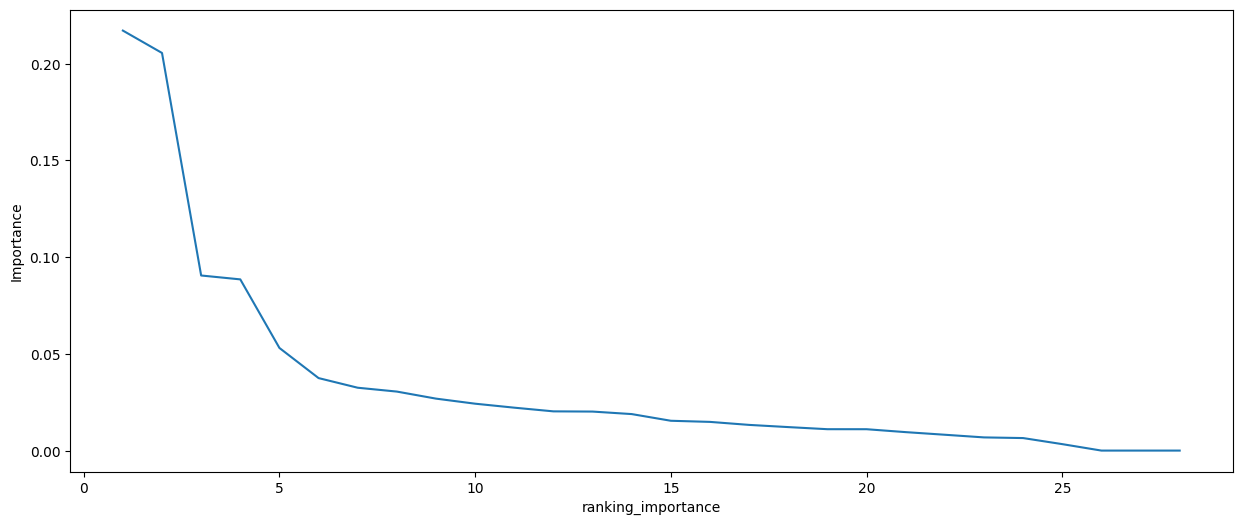

                          feature  Importance  ranking_importance
2   number_customer_service_calls    0.217144                   1
1              international_plan    0.205574                   2
5                total_day_charge    0.090522                   3
6               total_day_minutes    0.088514                   4
16                voice_mail_plan    0.053055                   5
10               total_intl_calls    0.037479                   6
3           number_vmail_messages    0.032493                   7
12             total_intl_minutes    0.030504                   8
8                total_eve_charge    0.026861                   9
9               total_eve_minutes    0.024240                  10
11              total_intl_charge    0.022183                  11
27       state_infrequent_sklearn    0.020278                  12
15            total_night_minutes    0.020168                  13
24                       state_VA    0.018870                  14
0         

In [16]:
importlib.reload(pp)
best_features = fs.feature_selection(X_train, y_train,  ratio, importance_threshold = 0.70)

In [17]:
best_features

['number_customer_service_calls',
 'international_plan',
 'total_day_charge',
 'total_day_minutes',
 'voice_mail_plan',
 'total_intl_calls']

In [18]:
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])
ratio

7.351893095768374

In [19]:
importlib.reload(pp)
best_model = mt.model_training(ratio, best_features, X_train, y_train)

**************************************************
get best hyper parameters

time_spend: 9.061866283416748


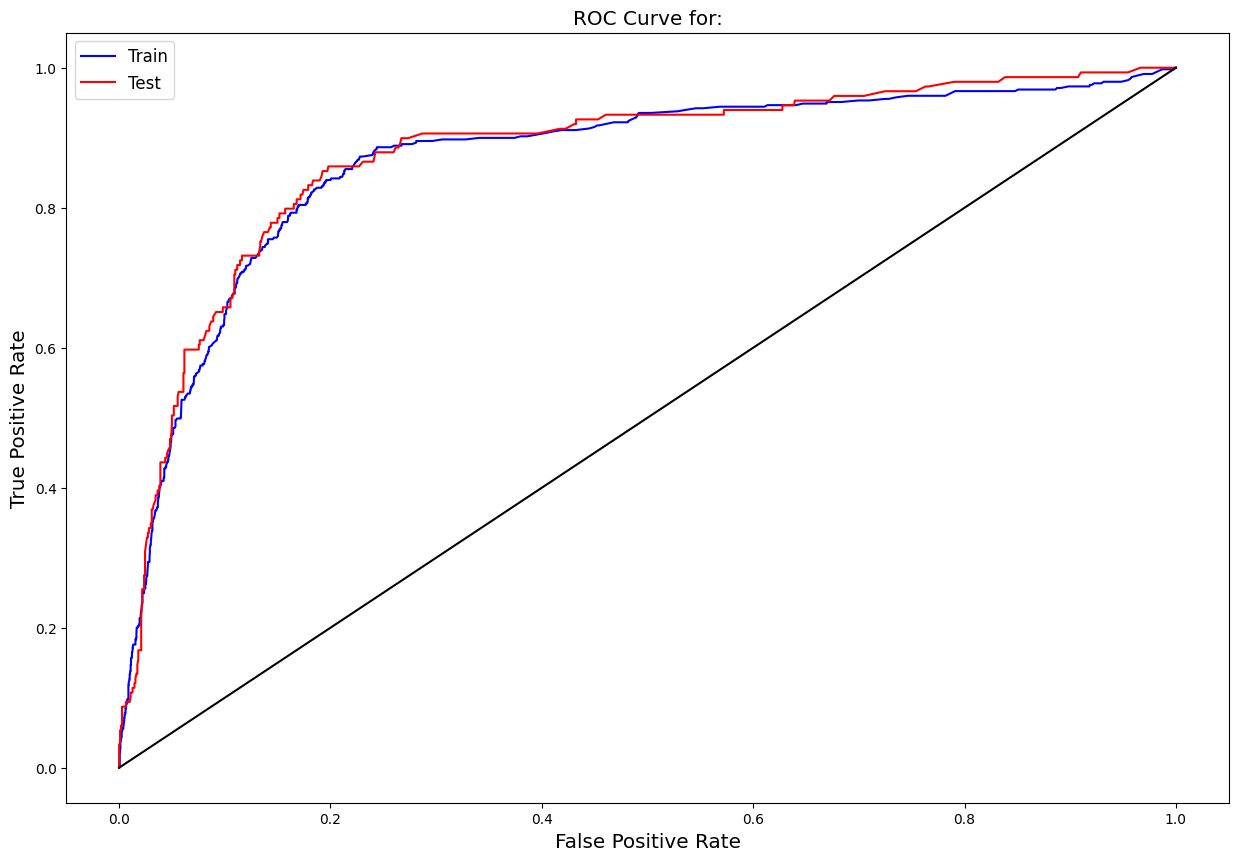

           Training down_sample  Training   Testing
Accuracy               0.827733  0.827733  0.833600
Recall                 0.792873  0.792873  0.798658
Precision              0.391639  0.391639  0.400673
F1-Score               0.524300  0.524300  0.533632
0.8753878414376193


<Figure size 640x480 with 0 Axes>

In [20]:
metrics_summary, y_test_pred, y_test_proba, y_train_proba,y_proba,y_pred, auc = me.model_evaluation(best_model, best_features, X_train, y_train, X_test, y_test, X_FE, y)

In [21]:
auc

0.8753878414376193

In [22]:
## Build final data
df_predict_actual                   = pd.DataFrame()
df_predict_actual['predict']        = y_pred
df_predict_actual['predict_prob']   = y_proba
df_predict_actual['customerID']         = df['ID']

df_predict_actual.head()

,predict,predict_prob,customerID
0,1,0.797343,1919
1,1,0.905294,1988
2,1,0.667889,3011
3,1,0.667889,3090
4,1,0.670364,3817


In [23]:
df_fixed    = df_predict_actual.sort_values(by = 'predict_prob', ascending = False).reset_index()
sample_size = df_predict_actual.shape[0]

# Segment the data into Decile size of 1
decile_size = sample_size/100 
df_fixed['Rank'] = ((df_predict_actual.index//decile_size)*1+1).astype('int64')

# df_fixed2 = df_fixed[df_fixed['Rank'] <= 20][['chc_id', 'Rank']]
df_fixed2 = df_fixed[['customerID', 'Rank']]
df_fixed2.head()

,customerID,Rank
0,1180,1
1,2328,1
2,2164,1
3,3652,1
4,1443,1


In [24]:
test_df = pd.concat([X_test[best_features], y_test], axis = 1)
test_df['Churn_probability'] = y_test_proba
test_df['y_pred'] = y_test_pred

In [25]:
test_df.head(2)

,number_customer_service_calls,international_plan,total_day_charge,total_day_minutes,voice_mail_plan,total_intl_calls,Churn,Churn_probability,y_pred
1472,1.0,0.0,30.0,179.0,0.0,6.0,0,0.286197,0
3599,2.0,0.0,26.0,156.0,0.0,2.0,0,0.377167,0


In [28]:
rank_df = test_df.copy()
rank_df = rank_df.rename(columns = {"y_pred": "Churn_prediction", "bucket": "prediction_probability_range"})
rank_df['customerID']         = df['ID']
# Step 1: Create percentile ranks (100 is highest, 1 is lowest)
rank_df['Rank'] = pd.qcut(rank_df['Churn_probability'], q=100, labels=False, duplicates='drop')

In [30]:
print(rank_df.shape)
rank_df.head()

(1250, 11)


,number_customer_service_calls,international_plan,total_day_charge,total_day_minutes,voice_mail_plan,total_intl_calls,Churn,Churn_probability,Churn_prediction,customerID,Rank
1472,1.0,0.0,30.0,179.0,0.0,6.0,0,0.286197,0,2137,20
3599,2.0,0.0,26.0,156.0,0.0,2.0,0,0.377167,0,2206,55
3180,2.0,0.0,16.0,98.0,0.0,5.0,0,0.345322,0,1561,43
233,0.0,0.0,36.0,213.0,0.0,3.0,0,0.262917,0,2136,9
2031,1.0,1.0,31.0,186.0,0.0,4.0,0,0.540959,1,4042,71


In [31]:
rank_df.to_csv('rank_df.csv', index = False)

In [32]:
min_val, max_val = (90, 100)

In [ ]:
min_val

90

In [33]:
import streamlit as st
from streamlit_shap import st_shap
import shap

In [34]:
rank_df[(rank_df['Rank'] >= min_val) & (rank_df['Rank'] <= max_val) ]

,number_customer_service_calls,international_plan,total_day_charge,total_day_minutes,voice_mail_plan,total_intl_calls,Churn,Churn_probability,Churn_prediction,customerID,Rank
4145,3.0,0.0,46.0,275.0,0.0,2.0,1,0.771325,1,1633,90
4889,5.0,1.0,36.0,216.0,0.0,2.0,0,0.840433,1,2170,91
4798,4.0,1.0,33.0,197.0,0.0,4.0,0,0.794592,1,2508,90
487,0.0,1.0,44.0,264.0,0.0,5.0,0,0.840222,1,3111,91
2079,1.0,1.0,49.0,288.0,1.0,5.0,0,0.835287,1,4331,91
4877,5.0,0.0,41.0,244.0,0.0,1.0,1,0.796642,1,2386,90
4599,3.0,0.0,45.0,265.0,0.0,1.0,0,0.770535,1,2442,90
4701,4.0,0.0,52.0,308.0,0.0,3.0,1,0.890846,1,1706,92
1137,1.0,1.0,53.0,312.0,0.0,2.0,1,0.904689,1,1990,92
12,9.0,1.0,40.0,237.0,1.0,3.0,1,0.848489,1,4803,91


In [35]:
test_df.Churn.value_counts()

Churn
0    1101
1     149
Name: count, dtype: Int64

In [36]:
importlib.reload(pp)
ks_df = ut.ks(data=test_df,target="Churn", prob= "Churn_probability")
ks_df

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.667956,0.968383,70,54,46.98%,4.90%,46.98%,4.90%,0.420752
2,0.563228,0.667889,39,82,26.17%,7.45%,73.15%,12.35%,0.60802
3,0.415358,0.560477,19,110,12.75%,9.99%,85.91%,22.34%,0.635627
4,0.367156,0.413588,7,119,4.70%,10.81%,90.60%,33.15%,0.574523
5,0.347173,0.365373,3,122,2.01%,11.08%,92.62%,44.23%,0.483849
6,0.328391,0.346796,1,117,0.67%,10.63%,93.29%,54.86%,0.384294
7,0.302557,0.328363,3,120,2.01%,10.90%,95.30%,65.76%,0.295436
8,0.280193,0.302161,3,119,2.01%,10.81%,97.32%,76.57%,0.207487
9,0.256564,0.279784,2,135,1.34%,12.26%,98.66%,88.83%,0.098294


In [37]:
X_test.columns

Index(['account_length', 'international_plan', 'number_customer_service_calls',
       'number_vmail_messages', 'total_day_calls', 'total_day_charge',
       'total_day_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_eve_minutes', 'total_intl_calls', 'total_intl_charge',
       'total_intl_minutes', 'total_night_calls', 'total_night_charge',
       'total_night_minutes', 'voice_mail_plan', 'area_code_area_code_415',
       'area_code_area_code_510', 'state_ID', 'state_MN', 'state_OH',
       'state_OR', 'state_TX', 'state_VA', 'state_WV', 'state_WY',
       'state_infrequent_sklearn'],
      dtype='object')

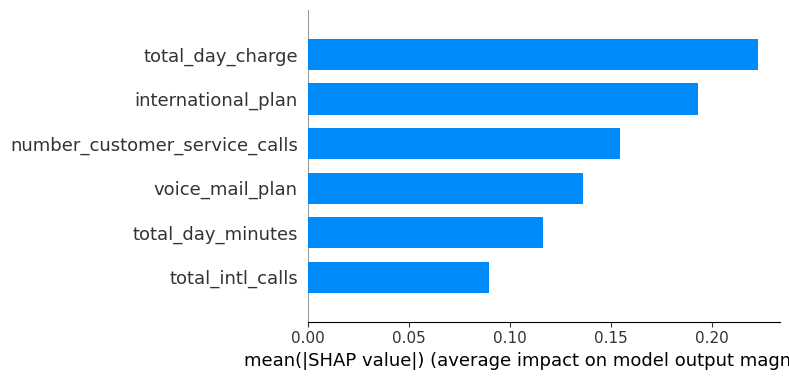

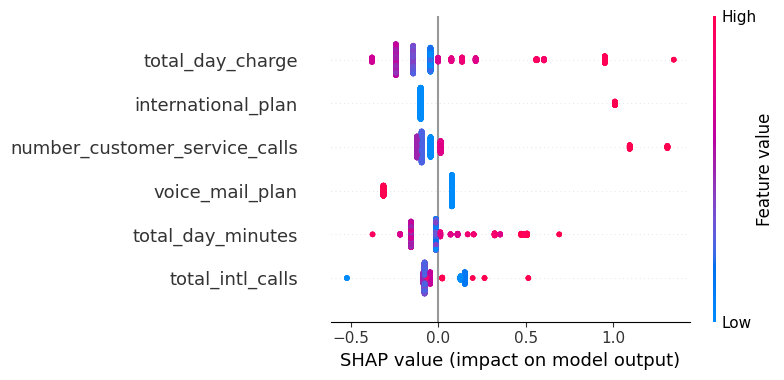

In [38]:
# SHAP
import shap
explainer = shap.Explainer(best_model, X_test[best_features])
shap_values = explainer(X_test[best_features])

# SHAP summary plot
shap.summary_plot(shap_values, X_test[best_features], plot_type= 'bar')



# SHAP beeswarm plot
shap.plots.beeswarm(shap_values, max_display = 20)

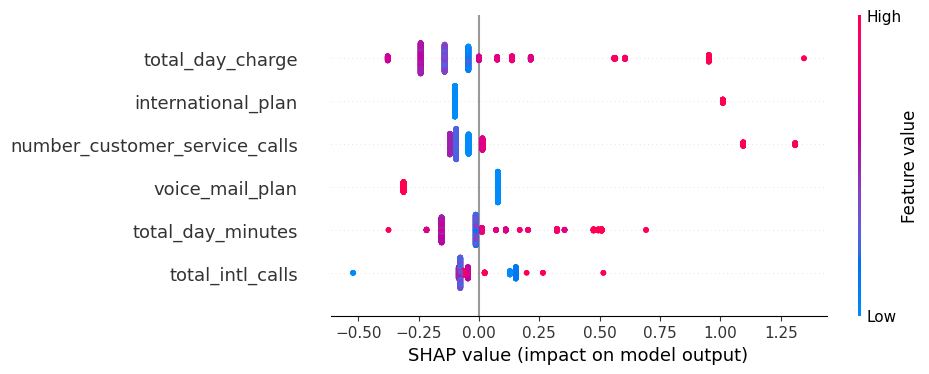

In [ ]:
plt.figure()
shap_plot = shap.plots.beeswarm(shap_values, show=False)

In [39]:
shap_plot.show()

NameError: name 'shap_plot' is not defined

In [40]:
# import plotly.express as px
# import dash_table
# from dash import html
# from explainerdashboard import ExplainerDashboard
# from explainerdashboard.custom import ExplainerComponent
# import dash_bootstrap_components as dbc


# class BeeswarmComponent(ExplainerComponent):
#     def __init__(self, explainer):
#         super().__init__(explainer, title="Beeswarm Plot")
        
#     def layout(self):
#         return html.Div([
#             html.H3("SHAP Beeswarm Plot"),
#             dcc.Graph(id="beeswarm-plot")
#         ])
    
#     def to_html(self, state_dict=None, add_header=True):
#         fig = self.explainer.plot_importances(kind="beeswarm")
#         html = to_html.fig(fig)
#         if add_header:
#             return to_html.add_header(html, "SHAP Beeswarm Plot")
#         return html

In [41]:
# # from explainerdashboard.custom import CustomDashComponent
# # from dash import html, dcc
# # import shap

# class BeeswarmComponent(ExplainerComponent):
#     def __init__(self, explainer, X_test, best_features):
#         super().__init__(explainer, X_test, best_features)
        
#     def layout(self):
#         return html.Div([
#             html.H3(self.title),
#             dcc.Graph(id="beeswarm-plot", figure=self.beeswarm_plot())
#         ])
    
#     def beeswarm_plot(self):
#         shap_values = self.explainer(X_test[best_features])
#         feature_names = self.explainer.columns
#         return shap.summary_plot(shap_values, self.explainer.X, 
#                                  feature_names=feature_names, 
#                                  plot_type="dot", 
#                                  show=False)
    
#     def to_html(self, state_dict=None, add_header=True):
#         fig = self.beeswarm_plot()
#         html_str = fig.to_html(full_html=False, include_plotlyjs='cdn')
#         if add_header:
#             return f"<h3>{self.title}</h3>{html_str}"
#         return html_str

In [42]:
# class BeeswarmComponent(ExplainerComponent):
#     def __init__(self, explainer, X_test, best_features, title="SHAP Beeswarm Plot"):
#         super().__init__(explainer, title)
        
#     def layout(self):
#         return html.Div([
#             html.H3(self.title),
#             dcc.Graph(id="beeswarm-plot", figure=self.beeswarm_plot())
#         ])
    
#     def beeswarm_plot(self):
        
#         X = self.X_test
#         feature_names = X.columns
#         best_features = self.best_features
#         # explainer(X_test[best_features])
#         explainer = self.explainer
#         # shap_values = explainer(X_test[best_features])
#         shap_values = explainer(X[best_features])
#         fig = shap.summary_plot(shap_values, X, 
#                                 feature_names=best_features, 
#                                 plot_type="dot", 
#                                 show=False)
#         return fig
    
#     def to_html(self, state_dict=None, add_header=True):
#         fig = self.beeswarm_plot()
#         html_str = fig.to_html(full_html=False, include_plotlyjs='cdn')
#         if add_header:
#             return f"<h3>{self.title}</h3>{html_str}"
#         return html_str


In [43]:
# from explainerdashboard.dashboards import ShapDependenceComponent, ShapSummaryComponent

In [44]:
# from explainerdashboard.custom import ExplainerComponent
# # import dash_html_components as html
# import dash_bootstrap_components as dbc
# from dash import html
# from dash import html, dcc

In [45]:
# shap_values = explainer(X_test[best_features])

In [47]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from explainerdashboard.dashboards import ShapDependenceComponent, ShapSummaryComponent
explainer = ClassifierExplainer(best_model, X_test[best_features], y_test)
# explainer = shap.Explainer(best_model, X_test[best_features])
# shap_values = explainer(X_test[best_features])

dashboard = ExplainerDashboard(explainer,  
    importances=True,
    model_summary=True,
    contributions=True,
    whatif=True,
    shap_dependence=False,
    shap_interaction=True,
    shap_summary=True,
    decision_trees=False
    )

Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Note: model_output=='probability'. For XGBClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...
Calculating shap values...
Calculating predicti

In [50]:
import os

host = os.environ.get('DASHBOARD_HOST', '0.0.0.0')
port = int(os.environ.get('DASHBOARD_PORT', 8050))

dashboard.run(host=host, port=port)

Starting ExplainerDashboard on http://192.168.1.98:8050


ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8050): Max retries exceeded with url: /_alive_e07ffaa9-10b3-4e01-bcae-20c653c7cc73 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000241878C1A90>: Failed to establish a new connection: [WinError 10049] The requested address is not valid in its context'))

In [52]:
dashboard.run(host='0.0.0.0', port=8051)  # or any other available port

Starting ExplainerDashboard on http://192.168.1.98:8051


ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8051): Max retries exceeded with url: /_alive_e07ffaa9-10b3-4e01-bcae-20c653c7cc73 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024186223190>: Failed to establish a new connection: [WinError 10049] The requested address is not valid in its context'))

Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []


In [49]:
# Run the dashboard on an external host
dashboard.run(host='0.0.0.0', port=8050)

Starting ExplainerDashboard on http://192.168.1.98:8050


ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8050): Max retries exceeded with url: /_alive_e07ffaa9-10b3-4e01-bcae-20c653c7cc73 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002418773ABE0>: Failed to establish a new connection: [WinError 10049] The requested address is not valid in its context'))

In [ ]:
pip install streamlit_dashboards

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement streamlit_dashboards (from versions: none)
ERROR: No matching distribution found for streamlit_dashboards

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install dash


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import dash

In [ ]:
import streamlit as st
# from streamlit_dashboards import Dashboard

st.title("My Streamlit App with ExplainerDashboard")

# Create the dashboard component
# dashboard_component = Dashboard(dashboard)

# Display the dashboard in Streamlit
st.write(dashboard)

2024-09-07 18:48:55.011 
  command:

    streamlit run d:\XtremeAnalytics\github_ml\venv\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [ ]:
# Run the dashboard on an external host
dashboard.run(host='localhost', port=8050)

Starting ExplainerDashboard on http://192.168.1.98:8050


In [ ]:
# Run the dashboard on an external host
dashboard.run(host='0.0.0.0', port=8053, use_waitress=True)

Starting ExplainerDashboard on http://192.168.1.98:8053


In [3]:
import streamlit as st

In [1]:
from google.oauth2 import service_account
from google.cloud import bigquery

In [5]:
# Create API client.
credentials = service_account.Credentials.from_service_account_info(
    st.secrets["gcp_service_account"]
)
client = bigquery.Client(credentials=credentials)

In [6]:
# Perform query.
# Uses st.cache_data to only rerun when the query changes or after 10 min.
@st.cache_data(ttl=600)
def run_query(query):
    query_job = client.query(query)
    rows_raw = query_job.result()
    # Convert to list of dicts. Required for st.cache_data to hash the return value.
    rows = [dict(row) for row in rows_raw]
    return rows

2024-09-08 17:01:07.560 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [8]:
rows = run_query("SELECT * FROM`ascendant-epoch-432900-m8.prop_model.new_churn` ")

2024-09-08 17:07:01.989 
  command:

    streamlit run d:\XtremeAnalytics\github_ml\venv\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-09-08 17:07:01.989 No runtime found, using MemoryCacheStorageManager


In [14]:
import pandas as pd

In [15]:
pd.DataFrame(rows)

,int64_field_0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Churn,ID
0,919,NJ,53,area_code_408,False,False,0,228.6,117,38.86,...,11.29,227.2,124,10.22,10.1,2,2.73,9,1,1919
1,988,KS,116,area_code_408,True,False,0,232.2,98,39.47,...,20.80,151.3,69,6.81,10.6,1,2.86,7,1,1988
2,2011,MI,146,area_code_408,False,False,0,149.3,83,25.38,...,15.90,149.8,100,6.74,7.9,4,2.13,7,1,3011
3,2090,HI,99,area_code_408,False,False,0,135.7,107,23.07,...,17.71,209.0,95,9.40,8.8,3,2.38,7,1,3090
4,2817,NH,103,area_code_408,False,False,0,150.6,125,25.60,...,14.37,221.2,104,9.95,10.4,8,2.81,8,1,3817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3227,OR,21,area_code_510,False,True,31,135.9,90,23.10,...,23.04,179.1,89,8.06,9.5,7,2.57,6,0,4227
4996,3944,NE,78,area_code_510,False,True,32,210.3,116,35.75,...,16.34,246.1,92,11.07,10.8,4,2.92,6,0,4944
4997,4155,UT,103,area_code_510,False,True,36,87.2,92,14.82,...,14.39,166.7,80,7.50,10.9,5,2.94,6,1,5155
4998,4682,MD,78,area_code_510,False,False,0,238.9,96,40.61,...,16.67,102.4,95,4.61,11.0,1,2.97,6,0,2432
